In [191]:
from ortools.linear_solver import pywraplp

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations, permutations
import time

In [356]:
number_tickets = 10
seating_rows = 20
seating_columns = 20
number_seats = seating_rows * seating_columns
seat_depth = 0.5
seat_depth_gap = 0.2
seat_width = 0.5
seat_width_gap = 0.2
max_group_size = 5

In [357]:
x_seats = np.array( [ (i % seating_columns) * (seat_width + seat_width_gap) + (seat_width / 2) for i in range(number_seats) ] )

In [358]:
y_seats = np.array( [ (i // seating_columns) * (seat_depth + seat_depth_gap) + (seat_depth / 2) for i in range(number_seats) ] )

In [359]:
#ticket_size = np.random.randint(low =1, high = 10, size = number_tickets)
ticket_size = np.ones(number_tickets)

In [360]:
ticket_size

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [361]:
48%7

6

In [362]:
solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')

In [363]:
x = {}

In [364]:
def create_pairs(max_group_size):
    return combinations(range(1, max_group_size+1), 2)

In [365]:
def create_variables(max_group_size):
    for i in range(1, max_group_size+1):
        for j in range(number_seats):
            x[(i, j)] = solver.IntVar(0, 1, '')

In [366]:
c=0
def get_min_distance(a, b, group1, group2):
    c=0
    distances = []
    distances.append((x_seats[a] - x_seats[b])**2 + (y_seats[a] - y_seats[b])**2)
    for i in range(group1):
        for j in range(group2):
            try:
                distances.append((x_seats[a+i] - x_seats[b+j])**2 + (y_seats[a+i] - y_seats[b+j])**2)
            except:
                c += 1
                #print(a,b)
    return min(distances)

In [367]:
def create_pair_constraints(one, two):
    for a, b in permutations(range(number_seats), 2):
        if get_min_distance(a, b, one, two) < 4:
            solver.Add(solver.Sum([ x[(one, a)] , x[(two, b)] ]) <= 1)
    

In [368]:
def create_individual_constraints(max_group_size):
    for i in range(1, max_group_size+1):
        for j in range(number_seats):
            if j % seating_columns >= seating_columns - i + 1:
                solver.Add(x[(i, j)] == 0)

In [369]:
def create_exclusivity_constraints(max_group_size):
    for j in range(number_seats):
        terms = [ x[(i, j)] for i in range(1, max_group_size + 1) ]
        solver.Add(solver.Sum(terms) <= 1)

In [370]:
def create_all_constraints(max_group_size):
    group_pairs = create_pairs(max_group_size)
    for pair in group_pairs:
        create_pair_constraints(pair[0], pair[1])
    
    group_self_pairs = [(d, d) for d in range(1, max_group_size+1)]
    for pair in group_self_pairs:
        create_pair_constraints(pair[0], pair[1])
        
    create_individual_constraints(max_group_size)
    
    create_exclusivity_constraints(max_group_size)
    

In [371]:
def main():
    # Data
    
        
    
    # Solver
    # Create the mip solver with the CBC backend.
    #solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')


    # Variables
    
    
    create_variables(max_group_size)
    
    # Constraints
    create_all_constraints(max_group_size)
    
    # Objective
    objective_terms = []
    for j in range(number_seats):
        for i in range(1, max_group_size):
            objective_terms.append( i * x[(i, j)] )
    
    solver.Maximize(solver.Sum(objective_terms))
    
    # Solve
    status = solver.Solve()
    
    print("status is ",status)
    
    #sol_matrix
    sol_matrices = []
    for i in range(max_group_size):
        sol_matrices.append(np.zeros((seating_rows, seating_columns)))
    # Print solution.
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print('Total cost = ', solver.Objective().Value(), '\n')
        for k in range(len(sol_matrices)):
            for i in range(seating_columns):
                for j in range(seating_rows):
                    # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                    if x[(k+1, i + j * seating_columns)].solution_value() > 0.5:
                        #print('Worker %d assigned to task %d.  Cost = %d' %
                              #(i, j, costs[i][j]))
                            
                            sol_matrices[k][j,i] = 1 * (k+1)
                    
        return(sol_matrices)
    else:
        return status


In [ ]:
t1 = time.time()
soln = main()
t2 = time.time()
t2-t1

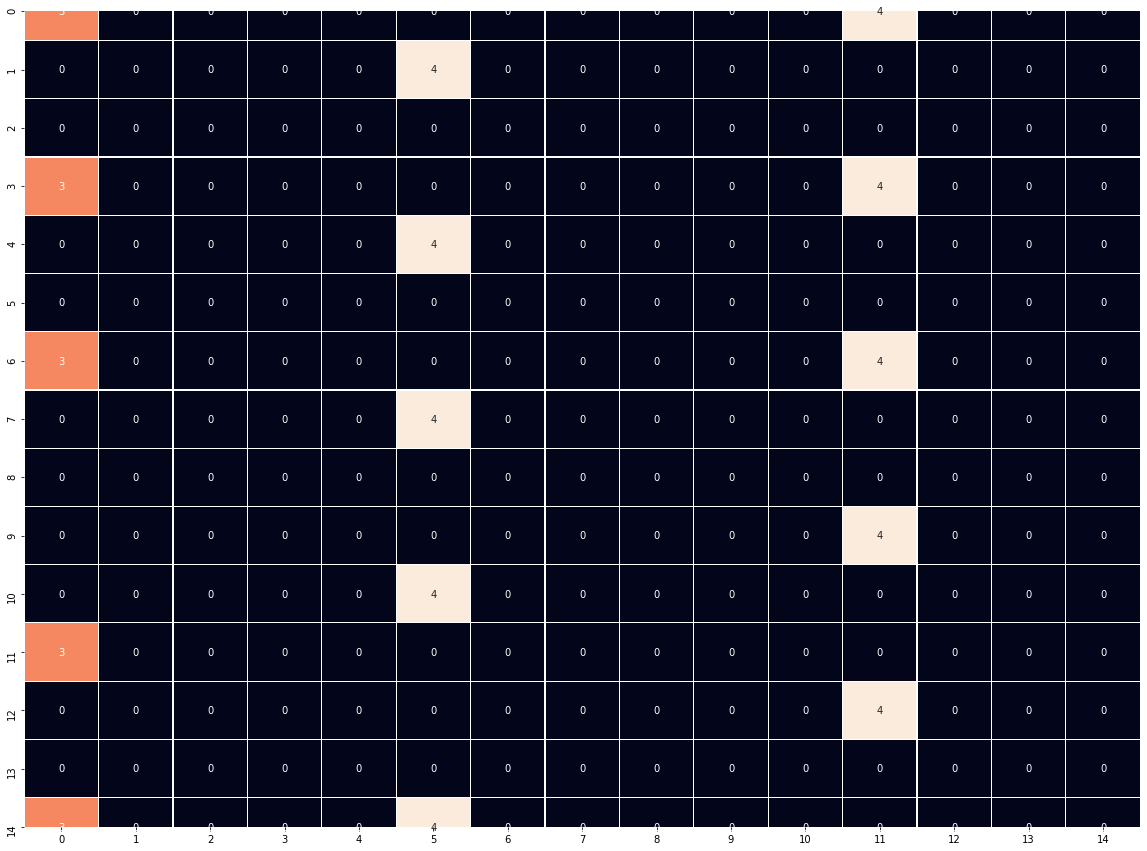

In [354]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(sum(soln), linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

In [355]:
pd.DataFrame(sum(soln)).to_csv("seating_optimization_for_225_seats_groups.csv")